In [1]:
import numpy as np
import math
import time
X = np.ndfromtxt('images.csv', delimiter=',')
y = np.ndfromtxt("labels.csv", delimiter=',', dtype=np.int8)
img_size = X.shape[1]
print("X={}  y={}".format(X.shape, y.shape))

X=(10000, 784)  y=(10000,)


In [2]:
# filter out only 0 and 1 and split data
ind = np.logical_or(y == 1, y == 0)
X = X[ind, :]
y = y[ind]
print("ind={}  sumind={}  X={}  y={}".format(ind.shape, np.sum(ind), X.shape, y.shape))

num_train = int(len(y) * 0.8)
X_train = X[0:num_train, :]
X_test = X[num_train:-1,:]
y_train = y[0:num_train]
y_test = y[num_train:-1]
print("X_train={}  X_test={}  y_train={}  y_test={}".format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

ind=(10000,)  sumind=2115  X=(2115, 784)  y=(2115,)
X_train=(1692, 784)  X_test=(422, 784)  y_train=(1692,)  y_test=(422,)


In [3]:
def h1(theta, x):
    sum = 0.0
    for i in range(len(x)):
        sum -= theta[i] * x[i]
    return 1 / (1 + math.exp(sum))

def h2(theta, x):
    return 1 / (1 + np.exp(np.dot(theta, x)))

theta = np.zeros([img_size])
print("theta.shape={}".format(theta.shape))
x = X[0,:]
%timeit h1(theta, x)
%timeit h2(theta, x)

theta.shape=(784,)
235 µs ± 2.79 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.1 µs ± 27.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Now we implement gradient descent, which was derived in the class notes 1, p.5:

$$\begin{align*}
\theta_j\mapsto\theta_j-\alpha\sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}
\end{align*}$$

where

$$\begin{align*}
h_\theta(x)=\frac{1}{1+e^{-\theta^Tx}}
\end{align*}$$

In [4]:
# doing everything element-wise

# multiply each observation x by the parameter vector theta
def h(theta, x):
    return 1 / (1 + np.exp(-np.dot(theta, x)))

def GD_elementwise(theta, X_train, y_train, alpha):
    # diff_arr.shape=(1692,)
    diff_arr = np.zeros([len(y_train)])
    for m in range(len(y_train)):
        # X_train[m, :].shape=(784, )  theta.shape=(784,)
        # np.dot(theta, x).shape = ()
        diff_arr[m] = h(theta, X_train[m, :]) - y_train[m]
    for j in range(len(theta)):
        s = 0.0
        for m in range(len(y_train)):
            s += diff_arr[m] * X_train[m, j]
        theta[j] = theta[j] - alpha * s
        
def train_elementwise(X_train, y_train, max_iter, alpha):
    theta = np.zeros([img_size])
    for i in range(max_iter):
        GD_elementwise(theta, X_train, y_train, alpha)       
    return theta
    
max_iter = 10
alpha = 0.01
start = time.time()
theta = train_elementwise(X_train, y_train, max_iter, alpha)
end = time.time()
print("time elapsed: {0} seconds".format(end - start))
# pred = (np.sign(h_vec(theta, X_test) - 0.5) + 1) / 2
# print("percentage correct: {0}".format(np.sum(pred == y_test) / len(y_test)))

/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


time elapsed: 4.671528100967407 seconds


In [5]:
#some vectorization

# to vectorize h=sigmoid, we multiply all observations (rows of X) by the parameter vector theta
# X_train.shape=(1692, 784)  theta.shape=(784,)
# matmul(X_train, theta).shape=(1692, )
def h_vec(theta, X):
    signal = np.clip( np.matmul(X, theta), -500, 500 )
    return 1 / (1 + np.exp(-signal))

def GD_better(theta,  X_train, y_train, alpha):
    diff_arr = h_vec(theta, X_train) - y_train
    for j in range(len(theta)):
        # diff_arr.shape=(1692,)  X_train[:, j].shape=(1692,)
        # np.dot(diff_arr, X_train[:, j]).shape = ()
        theta[j] = theta[j] - alpha * np.dot(diff_arr, X_train[:, j])
        
def train_better(X_train, y_train, max_iter, alpha):
    theta = np.zeros([img_size])
    for i in range(max_iter):
        GD_better(theta, X_train, y_train, alpha)       
    return theta
    
max_iter = 10
alpha = 0.01
start = time.time()
theta = train_better(X_train, y_train, max_iter, alpha)
end = time.time()
print("time elapsed: {0} seconds".format(end - start))
pred = (np.sign(h_vec(theta, X_test) - 0.5) + 1) / 2
print("percentage correct: {0}".format(np.sum(pred == y_test) / len(y_test)))

time elapsed: 0.12651896476745605 seconds
percentage correct: 1.0


In [14]:
#fully vectorized
def GD (theta, X_train, y_train, alpha):
    # X_train.shape=(1692, 784)  theta.shape=(784,)
    # diff.shape = matmul(X_train, theta).shape=(1692, )
    diff = h_vec(theta, X_train) - y_train
    # reshape(diff, [1, -1]).shape = (1,1692)
    diff = np.reshape(diff, [1, -1])
    # dx.shape = (1, 1692)*(1692, 784)=(1,784)
    dx = np.matmul(diff, X_train)
    # np.squeeze(dx).shape = (784,)
    theta -= alpha * np.squeeze(dx)
    return theta
    
def train_vec(X_train, y_train, max_iter, alpha):
    theta = np.zeros([img_size])
    for i in range(max_iter):
        theta = GD(theta, X_train, y_train, alpha)       
    return theta

max_iter = 10000
alpha = 0.01
start = time.time()
theta = train_vec(X_train, y_train, max_iter, alpha)
end = time.time()
print("time elapsed: {0} seconds".format(end - start))
pred = (np.sign(h_vec(theta, X_test) - 0.5) + 1) / 2
print("percentage correct: {0}".format(np.sum(pred == y_test) / len(y_test)))

time elapsed: 6.378481864929199 seconds
percentage correct: 1.0


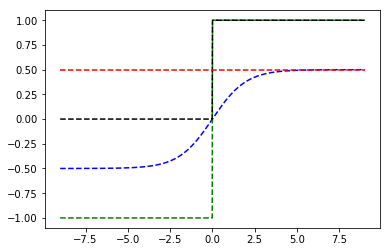

In [7]:
import matplotlib.pyplot as plt

def graph_ineff(funct, x_range, cl='r--', show=False):
    y_range=[]                                                                                   
    for x in x_range:
        y_range.append(funct(x))
    plt.plot(x_range,y_range,cl)
    if show: plt.show()

xr=np.linspace(-9,9,1000)
graph_ineff(lambda z: 1/(1+np.exp(-z))-1/2,xr,cl='b--')
graph_ineff(lambda z: np.sign(1/(1+np.exp(-z))-1/2),xr,cl='g--')
graph_ineff(lambda z: (np.sign(1/(1+np.exp(-z))-1/2)+1)/2,xr,cl='k--')
graph_ineff(lambda z: 1/2,xr, show=True)